In [51]:
import pandas as pd
import numpy as np
import trimesh

from scipy.spatial import ConvexHull
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt
import igl

from ghcn_helper import *


In [52]:
date_start, date_end = "20180101", "20181231"
yearbook = build_yearbook(date_start, date_end, ["TMAX", "TMIN"])
persistent_stations = find_persistent_stations(date_start, date_end, yearbook)
all_stations = find_all_stations(date_start, date_end, yearbook)


Found 4968 persistent stations in date range 20180101-20181231
After removing dups:  4968
Found 14046 stations in total in date range 20180101-20181231
After removing dups:  14046


In [53]:
def df2points(df):
    zeniths, azimuths = geographical2spherical(df["latitude"], df["longitude"])
    return spherical2cartesian(zeniths, azimuths)


In [116]:
ps_points = df2points(persistent_stations)
ps_points = ps_points.T
ps_points


array([[-0.66421637,  0.42899735, -0.61219106],
       [-0.65503874,  0.43397677, -0.61853732],
       [-0.23153037, -0.69290763,  0.68284164],
       ...,
       [ 0.60625208,  0.10045244,  0.78890286],
       [ 0.58350829,  0.14541032,  0.79898305],
       [ 0.64606004,  0.10062856,  0.75662429]])

In [112]:
# ch = ConvexHull(ps_points)
ch = ConvexHull(df2points(all_stations).T)

V = ch.points
F = ch.simplices
mesh = trimesh.Trimesh(vertices=V, faces=F, process=False)
assert mesh.is_watertight
assert mesh.euler_number == 2
# mesh.show()
# mesh.export("persistent_stations.obj")
mesh.export("all_stations.obj")


'v -0.63778741 0.66886095 -0.38190608\nv -0.66421637 0.42899735 -0.61219106\nv -0.65503874 0.43397677 -0.61853732\nv 0.21723892 -0.66661269 0.71304612\nv -0.08010599 -0.59903456 0.79670611\nv 0.98092666 -0.01969110 0.19337823\nv 0.24453527 -0.65737047 0.71278788\nv -0.23153037 -0.69290763 0.68284164\nv -0.37702306 -0.58952773 0.71436033\nv 0.11467254 -0.87578405 0.46888432\nv 0.12655924 -0.87331469 0.47042981\nv 0.22581791 -0.72200755 0.65399646\nv -0.38868893 -0.67486007 0.62728367\nv -0.23979316 -0.78995604 0.56433031\nv 0.09226851 -0.78699723 0.61001794\nv -0.25585571 -0.67667742 0.69039519\nv -0.06434398 -0.77612824 0.62728367\nv -0.34692610 -0.63001397 0.69478391\nv -0.30542319 -0.59710620 0.74174177\nv -0.29645610 -0.65780152 0.69239507\nv -0.30374702 -0.67618337 0.67120325\nv -0.27569906 -0.63924451 0.71788333\nv -0.28703470 -0.62607188 0.72501385\nv -0.26659521 -0.68167127 0.68135987\nv -0.27153706 -0.68722567 0.67378668\nv -0.24649200 -0.74970966 0.61414747\nv -0.26152669 -0.5

In [117]:
from ghcn_spectrum import *
import time

start = time.time()
for _ in range(10):
    L, M = compute_cotan_laplacian(ps_points)
end = time.time()
print("time taken: ", end - start)



time taken:  0.3744189739227295


(array([ 444.,  774.,  680.,  464.,  386.,  312.,  248.,  201.,  169.,
        1290.]),
 array([0.e+00, 1.e-05, 2.e-05, 3.e-05, 4.e-05, 5.e-05, 6.e-05, 7.e-05,
        8.e-05, 9.e-05, 1.e-04]),
 <a list of 10 Patch objects>)

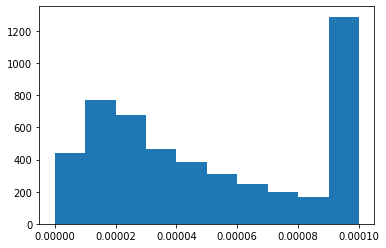

In [122]:
diag = M.diagonal()
diag = np.clip(diag, a_min=0, a_max=0.0001)
# plt.xscale("log")
plt.hist(diag)


In [60]:
ML = diagonal_inverse(M) @ L


TYPE INV:  float64
CLOSE TO ZERO: 0.0


/Users/dwd/anaconda3/lib/python3.6/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


CLOSE TO ZERO: 0.0


In [91]:
eigvec = power_iteration(ML, tol=1E-20, max_steps=10000)
np.linalg.norm(eigvec)


Loss=4.440892098500626e-16 at step 999
Successfully converged after 1024 steps


1.0

In [92]:
eigval = eigvec.T @ (ML @ eigvec)
eigval


199340433.12281135

In [93]:
rhs = ML @ eigvec
lhs = eigval * eigvec
diff = np.linalg.norm(rhs - lhs, ord=2)
diff


4.337277417890018